# <b><font color=grey>Yanan Zhou</font> <span style='color:#9268f6'>|</span><font color=grey> Takehome DS Written Project</b>
The dataset has future merchant transaction activity, for merchants that start over a 2 year period (2033-2034). The data spans from 1/1/33 through 12/31/34. Although the data is made up, you can consider this to be a random sample of future merchants using Stripe. Each observation is a transaction amount in cents. If the merchant stops processing with Stripe, then they would no longer appear.

In [1]:
# basic libraries/packages
import numpy as np
import pandas as pd
import datetime

# plot
from matplotlib import pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

# model & Selection
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter("ignore")

----

# <b><font color=grey>1</font> <span style='color:#9268f6'>|</span><font color=grey> Merchant Segmentation</b>
    We have limited data on these merchants and their transactions, but we are still interested in understanding 
    their payments activity to try to infer the types of merchants using Stripe. Using only the given data, how 
    would you identify different kinds of businesses in the sample? Please generate assignments for each merchant.

<div style="color:white;display:fill;border-radius:6px;
            background-color:#9268f6;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.1 | Import and Check the data</b></p>
</div>
<div style="color:white;display:fill;border-radius:6px;
            background-color:#e45789;font-size:150%;opacity: 0.8;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"></p>
</div>

In [2]:
df=pd.read_csv('takehome_ds_written.csv',index_col=0)
df[:10]

,merchant,time,amount_usd_in_cents
1,faa029c6b0,2034-06-17 23:34:14,6349
2,ed7a7d91aa,2034-12-27 00:40:38,3854
3,5608f200cf,2034-04-30 01:29:42,789
4,15b1a0d61e,2034-09-16 01:06:23,4452
5,4770051790,2034-07-22 16:21:42,20203
6,3fc4f08d9d,2034-08-12 10:54:48,6190
7,1c8b539073,2033-03-10 18:46:49,715
8,77f961f9b3,2034-12-09 21:27:18,7211
9,9cb79b7700,2034-03-27 23:01:13,23267
10,2f95149dc3,2034-01-24 21:17:22,2572


In [3]:
# check the data type of each feature
df.dtypes

merchant               object
time                   object
amount_usd_in_cents     int64
dtype: object

In [4]:
# check the total size and the number of unique merchant of the dataset
df.shape,df['merchant'].unique().shape

((1513719, 3), (14351,))

In [5]:
# check for the missing value
df.isnull().sum()

merchant               0
time                   0
amount_usd_in_cents    0
dtype: int64

<div style="color:white;display:fill;border-radius:6px;
            background-color:#9268f6;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.2 | Generate Merchant Features</b></p>
</div>
<div style="color:white;display:fill;border-radius:6px;
            background-color:#e45789;font-size:150%;opacity: 0.8;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"></p>
</div>

* <font color=#9268f6>__Contribution Ability:__</font> Average amount per transaction
* <font color=#9268f6>__Total Contribution:__</font> Total amount of all the transaction
* <font color=#9268f6>__Period:__</font> The number of days between the first purchase and the last purchase
* <font color=#9268f6>__Activeness(Frequency):__</font> One order every few days on average = (Period)/(total transaction times)
* <font color=#9268f6>__Freshness:__</font> The number of days since the merchant has been using the app = '2035-1-1' - Start_Using_Date
* <font color=#9268f6>__Recency:__</font> The number of days since the last purchase time = '2035-1-1' - Last_Using_Date

In [6]:
# convert "cent" to "dollar"
df['amount_usd']=df['amount_usd_in_cents']/100

# convert 'time' to datetime
df['time']=pd.to_datetime(df['time'])

# the average transaction amount and total transaction times of each merchant
df_p=pd.DataFrame(df.groupby('merchant')['amount_usd'].agg(['sum','mean','count']))

# the start/last date and total using period of each merchant
df_tr=pd.DataFrame(df.groupby('merchant')['time'].agg(['min','max']))
df_tr['Period']=(df_tr['max']-df_tr['min']).dt.days+1

df1=pd.concat([df_tr,df_p],axis=1).rename(columns={'sum':'Total_Contribution','min':'start_date','max':'last_date',
                                                   'mean':'Contribution_Ability','count':'total_times'})

# calculate the "Activeness"
df1['Activeness']=round(df1['Period']/df1['total_times']+1,3)

# calculate the "Freshness"
df1['Freshness']=(1+(datetime.datetime(2035,1,1,0,0,0)-df1['start_date']).dt.days)

# calculate the "Recency"
df1['Recency']=(datetime.datetime(2035,1,1,0,0,0)-df1['last_date']).dt.days+1

df2=df1.drop(columns=['start_date','last_date','total_times'])
df2[:10]

,Period,Total_Contribution,Contribution_Ability,Activeness,Freshness,Recency
merchant,,,,,,
0002b63b92,1,33.79,33.790000,2.000,595,595
0002d07bba,65,892.78,223.195000,17.250,82,17
00057d4302,67,295.21,10.543214,3.393,581,515
000bcff341,1,78.26,78.260000,2.000,510,510
000ddbf0ca,1,102.99,102.990000,2.000,578,578
000ed1585f,657,16472.67,265.688226,11.597,682,26
000f8c3297,457,34551.91,119.144517,2.576,459,2
001f7b7a4f,1,64.44,64.440000,2.000,305,305
0020aefbd9,23,130.04,65.020000,12.500,216,193


<div style="color:white;display:fill;border-radius:6px;
            background-color:#9268f6;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.3 | Exploratory Data Analysis</b></p>
</div>
<div style="color:white;display:fill;border-radius:6px;
            background-color:#e45789;font-size:150%;opacity: 0.8;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"></p>
</div>

In [7]:
df2.describe()

,Period,Total_Contribution,Contribution_Ability,Activeness,Freshness,Recency
count,14351.000000,1.435100e+04,14351.000000,14351.000000,14351.000000,14351.000000
mean,200.478085,1.633296e+04,381.045794,15.386785,337.881054,137.961605
std,203.849367,6.431726e+04,1415.186160,24.413067,205.578134,174.498650
min,1.000000,2.010000e+00,2.010000,1.000000,1.000000,1.000000
25%,18.000000,3.626300e+02,57.381817,2.000000,159.000000,11.000000
50%,128.000000,1.602620e+03,109.650000,6.000000,326.000000,52.000000
75%,349.000000,8.230995e+03,273.212222,17.600000,510.000000,214.000000
max,729.000000,2.369072e+06,88874.651667,363.500000,730.000000,729.000000


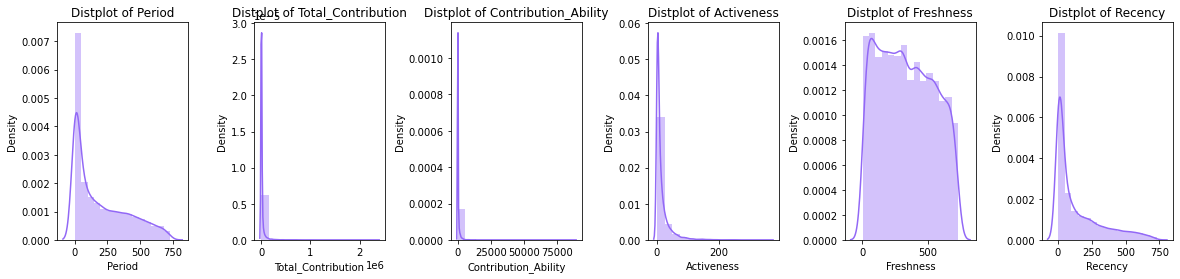

In [8]:
plt.figure(1 , figsize = (20 , 4))
n = 0 
for x in df2.columns:
    n += 1
    plt.subplot(1 , 6 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df2[x] , bins = 15, color='#9268f6')
    plt.title('Distplot of {}'.format(x))
plt.show()

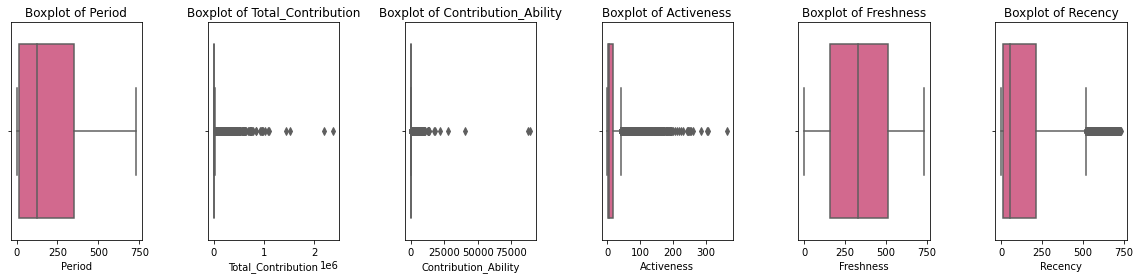

In [9]:
plt.figure(1 , figsize = (20 , 4))
n = 0 
for x in df2.columns:
    n += 1
    plt.subplot(1 , 6 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.boxplot(df2[x],color="#e45789")
    plt.title('Boxplot of {}'.format(x))
plt.show()

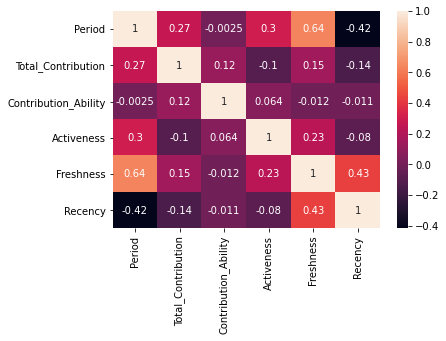

In [10]:
sns.heatmap(df2.corr(),annot=True,color='pink')

### <font color=#9268f6>__Conclusion:__ </font>
* #### <font color=#9268f6>The generated features are mostly right skewed</font>
* #### <font color=#9268f6>Some generated features are extremely centered</font>
* #### <font color=#9268f6>Most of the generated features are little correlated with each other</font>

<div style="color:white;display:fill;border-radius:6px;
            background-color:#9268f6;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.4 | Clustering by KMeans</b></p>
</div>
<div style="color:white;display:fill;border-radius:6px;
            background-color:#e45789;font-size:150%;opacity: 0.8;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"></p>
</div>

In [11]:
# scale the data
scaler=StandardScaler()
scaler.fit(df2)
df2_scale=scaler.transform(df2)

df2scale=pd.DataFrame(df2_scale,columns=['Period','Total_Contribution','Contribution_Ability',
                                         'Activeness','Freshness','Recency'])
df2scale[:10]

,Period,Total_Contribution,Contribution_Ability,Activeness,Freshness,Recency
0,-0.978590,-0.253427,-0.245387,-0.548364,1.250755,2.619243
1,-0.664622,-0.240071,-0.111545,0.076323,-1.244733,-0.693219
2,-0.654811,-0.249362,-0.261814,-0.491303,1.182652,2.160770
3,-0.978590,-0.252736,-0.213962,-0.548364,0.837273,2.132116
4,-0.978590,-0.252351,-0.196487,-0.548364,1.168059,2.521817
5,2.239584,0.002172,-0.081517,-0.155241,1.673967,-0.641641
6,1.258433,0.283277,-0.185071,-0.524769,0.589183,-0.779183
7,-0.978590,-0.252951,-0.223728,-0.548364,-0.159950,0.957281
8,-0.870664,-0.251931,-0.223318,-0.118252,-0.592890,0.315420
9,-0.546884,-0.214945,-0.047662,-0.133613,1.090227,1.920073


In [12]:
# using "inertia" and "silhouette_avg" to select the best parameter "n_clusters"
inertia = []
silhouette_avg = []
for n in range(2 , 15):
    cluster = KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                     tol=0.0001,  random_state= 111  , algorithm='elkan') 
    cluster.fit(df2_scale)
    inertia.append(cluster.inertia_)
    silhouette_avg.append(silhouette_score(df2_scale,cluster.labels_))

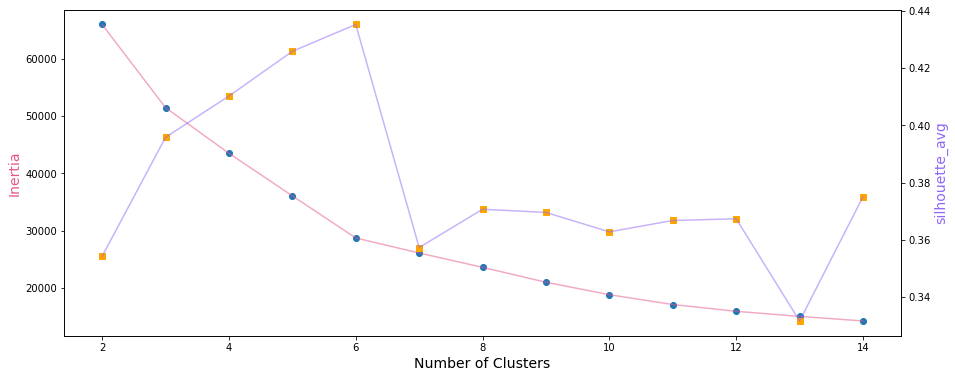

In [13]:
fig,ax = plt.subplots(1 , figsize = (15 ,6))
ax.plot(np.arange(2 , 15) , inertia , 'o')
ax.plot(np.arange(2 , 15) , inertia , '-' , alpha = 0.5 , color='#e45789')
ax.set_xlabel('Number of Clusters',fontsize=14)
ax.set_ylabel('Inertia',color="#e45789",fontsize=14)

ax2=ax.twinx()
ax2.plot(np.arange(2 , 15) , silhouette_avg , 's',color='orange')
ax2.plot(np.arange(2 , 15) , silhouette_avg , '-' , alpha = 0.5 , color='#9268f6')
ax2.set_ylabel('silhouette_avg',color="#9268f6",fontsize=14)

plt.show()

### <font color=#9268f6>__Condidering both "inertia" and "silhouette_avg", the best value of "n_clusters" is 6.__</font>

In [14]:
# use "n_clusters=6" as the model parameter
cluster = KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') 
cluster.fit(df2_scale)
labels = cluster.labels_
centroids = cluster.cluster_centers_

In [15]:
# see the number of merchants in each cluster
df2scale['label']=labels
df2scale.groupby('label').agg('count').iloc[:,0]

label
0       3
1    6786
2     957
3    2723
4     116
5    3766
Name: Period, dtype: int64

### <font color=#9268f6>__Then we can use paired scatter plot and boxplot to see the features distribution in each cluster:__</font>

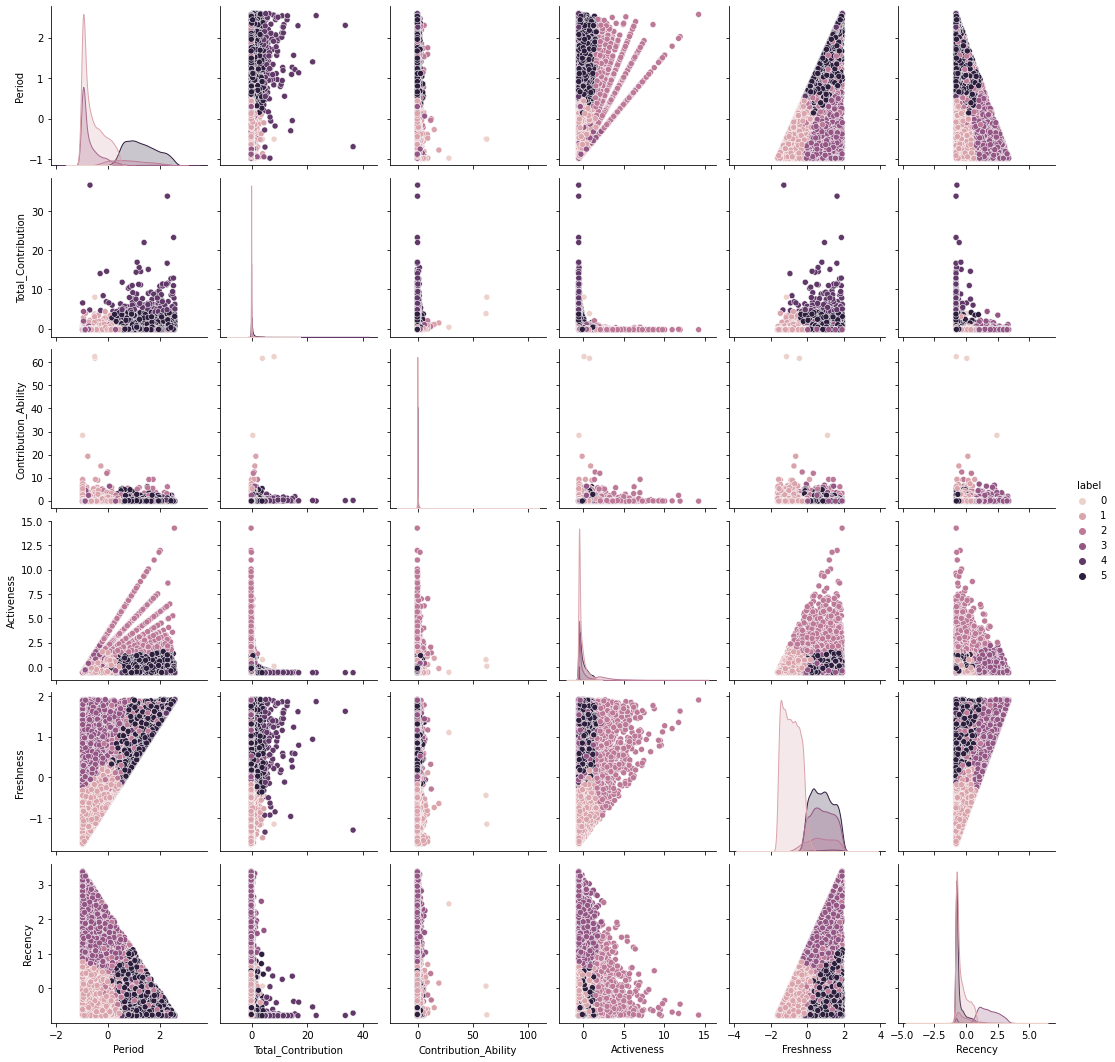

In [16]:
# paired scatter plot
sns.pairplot(df2scale, hue ='label')

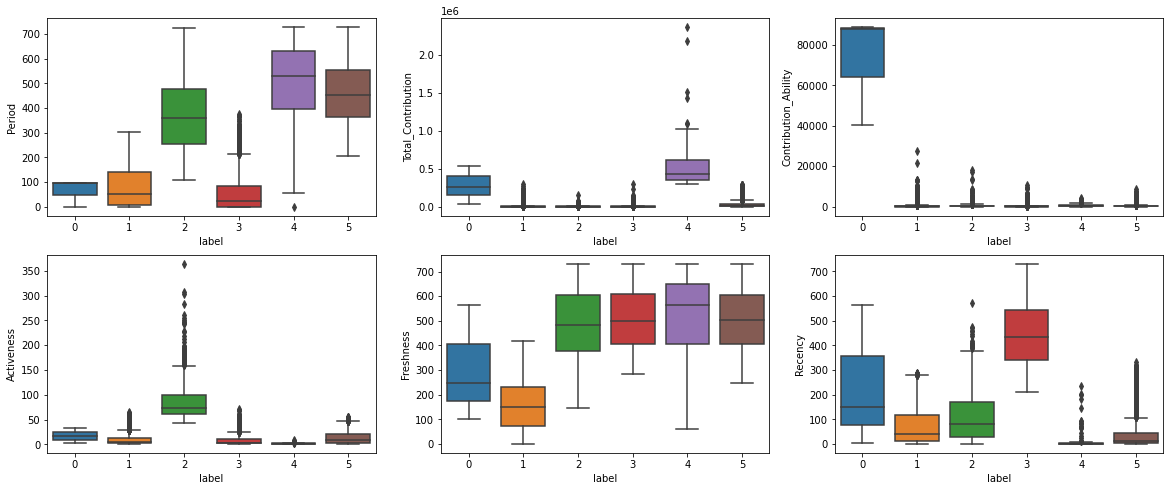

In [17]:
# boxplot
df2['label']=labels
name=locals()
fig,((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3, figsize = (20,8))
for i in range(6):
    sns.boxplot(x='label', y=df2.iloc[:,i], data=df2,ax=name['ax'+str(i)])

<div style="color:white;display:fill;border-radius:6px;
            background-color:#9268f6;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>1.5 | Sum Up the Charactistics of Each Type of Merchants</b></p>
</div>
<div style="color:white;display:fill;border-radius:6px;
            background-color:#e45789;font-size:150%;opacity: 0.8;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"></p>
</div>

|        | Period | Total_Contribution | Contribution_Ability | Activeness | Freshness | Recency | <font color=#9268f6>Characteristics</font> |
| :----: | :----: |  :----:          | :----:             | :----:       | :----:      |:----:     |:----    |
| 0      | short  | slightly larger | very large | high-frequency | relatively new| relatively long|  <font color=#9268f6>**Customers who only use in a very short period with extremely large number of transaction**</font>
| 1      | slightly shorter  | small| mostly small<br/>some large| high-frequency| new | mostly short| <font color=#9268f6>**New customers with high-frequency of use and relatively good contribution ability**</font>
| 2      | long  | small| mostly small<br/>some large| low-frequency | old | mostly short| <font color=#9268f6>**Old customers with low-frequency of use and relatively good contribution ability**</font>
| 3      | mostly short | mostly small| small | low-frequency | old | long |<font color=#9268f6>**Old customers who have not used for a long time with low-frequency of use and low contribution ability**</font>
| 4      | mostly long  | large | small | very high-frequency| mostly old | short |<font color=#9268f6>**Old customers who keep using with high-frequency of use and small contribution ability, but large total amount**</font>
| 5      | long | small | small | slightly low-frequency | old | short | <font color=#9268f6>**Old customers who keep using with low-frequency of use and small contribution ability**</font>

### <font color=#9268f6>__More Genaral Conclusion:__</font>

---

# <b><font color=grey>2</font> <span style='color:#9268f6'>|</span><font color=grey> Churn Analysis</b>
    Sometimes a merchant may stop processing with Stripe, which we call churn. We are interested in identifying and predicting churn. Please:
    a) come up with a concrete definition for churn; 
    b) identify merchants that have already churned in the dataset;
    c) build a model to predict which active merchants are most likely to churn in the near future.

<div style="color:white;display:fill;border-radius:6px;
            background-color:#9268f6;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.1 | Definition of Churn</b></p>
</div>
<div style="color:white;display:fill;border-radius:6px;
            background-color:#6be6e1;font-size:150%;opacity: 0.8;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"></p>
</div>

    Although the “Recency” of some merchants are large, they may have used Stripe less often than others. In other words, two merchants may have not used Stripe for the same days(i.e. 6 days), the merchant with “Activeness=2” may be more likely to have been churned compared to the merchant with “Activeness=12”.  
    The longer using period is, the more likely user rely on Stripe.

    Thus, we can give "Churn" a definition with considering "Recency”, "Activeness" and “Period”: 

###  <center><font color = #9268f6>**$Relative Leaving Possibility=\frac{Recency}{Activeness}$**</font></center><br/><center><font color = #9268f6>**$ChurnScore = \frac{1}{2}Relative Leaving Possibility + \frac{1}{2}\frac{100}{Period}$**</font></center>

In [18]:
df2['ChurnScore']=0.5*df2['Recency']/df2['Activeness']+50/df2['Period']
print(df2['ChurnScore'].describe())
print('------------------------------------')
print('80% Quantile: '+str(df2['ChurnScore'].quantile(0.8)))

count    14351.000000
mean        31.085130
std         56.976897
min          0.074468
25%          0.810949
50%          3.215008
75%         33.589646
max        396.634615
Name: ChurnScore, dtype: float64
------------------------------------
80% Quantile: 55.25


In [19]:
df2['Churn']=np.where(df2['ChurnScore']>df2['ChurnScore'].quantile(0.8),1,0)
df2.groupby('Churn').agg('count').iloc[:,0]

Churn
0    11482
1     2869
Name: Period, dtype: int64

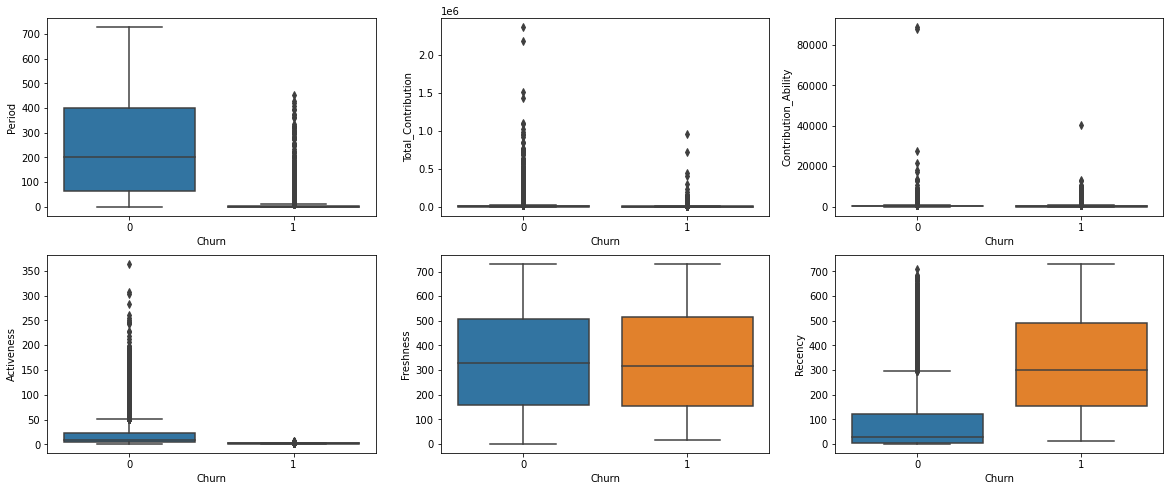

In [20]:
fig,((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3, figsize = (20,8))
for i in range(6):
    sns.boxplot(x='Churn', y=df2.iloc[:,i], data=df2,ax=name['ax'+str(i)])

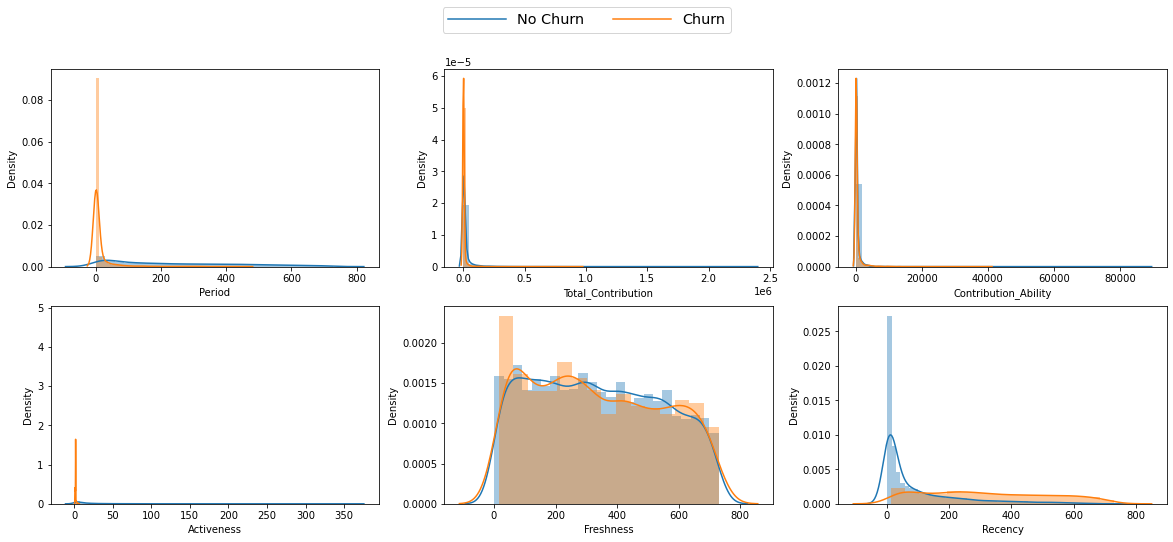

In [21]:
fig,((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3, figsize = (20,8))
for i in range(6):
    sns.distplot(df2[df2['Churn']==0].iloc[:,i],label='No Churn',ax=name['ax'+str(i)])
    sns.distplot(df2[df2['Churn']==1].iloc[:,i],label='Churn',ax=name['ax'+str(i)])
fig.legend(labels=['No Churn','Churn'],loc='upper center',fontsize='x-large',handlelength=4,ncol=2)

<div style="color:white;display:fill;border-radius:6px;
            background-color:#9268f6;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.2 | Merchants Who Have Already Churned</b></p>
</div>
<div style="color:white;display:fill;border-radius:6px;
            background-color:#6be6e1;font-size:150%;opacity: 0.8;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"></p>
</div>

In [22]:
df2[df2['Churn']==1].describe()

,Period,Total_Contribution,Contribution_Ability,Activeness,Freshness,Recency,label,ChurnScore,Churn
count,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.0
mean,14.059603,4636.451941,403.214590,1.935873,335.941094,322.655629,2.083653,126.176998,1.0
std,43.572391,28907.847904,1252.662174,0.656274,208.863087,199.686216,1.017271,65.820632,0.0
min,1.000000,2.090000,2.060000,1.000000,15.000000,14.000000,0.000000,55.281411,1.0
25%,1.000000,123.250000,52.990000,1.500000,154.000000,153.000000,1.000000,74.750000,1.0
50%,1.000000,366.730000,106.335000,2.000000,317.000000,302.000000,3.000000,106.442308,1.0
75%,5.000000,1633.150000,269.460000,2.000000,514.000000,490.000000,3.000000,160.666667,1.0
max,455.000000,957098.710000,40475.210000,6.500000,730.000000,729.000000,5.000000,396.634615,1.0


In [23]:
df2[df2['Churn']==1].groupby('label').agg('count').iloc[:,1]

label
0       1
1    1328
3    1523
4       4
5      13
Name: Total_Contribution, dtype: int64

<div style="color:white;display:fill;border-radius:6px;
            background-color:#9268f6;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.3 | Churn Prediction Model </b></p>
</div>
<div style="color:white;display:fill;border-radius:6px;
            background-color:#6be6e1;font-size:150%;opacity: 0.8;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"></p>
</div>

In [24]:
# get dummy variables for "label" ----> the type we got from the previous segmentation
df2['label']=df2['label'].astype('category')
df_dummies = pd.get_dummies(df2)

X=df_dummies.drop(columns=['Churn','ChurnScore']).copy()
y=df_dummies['Churn'].copy()

In [25]:
# upsampling the "churn" class
oversample = SMOTE()
X_os, y_os = oversample.fit_resample(X, y)
print(X.shape, y.shape)
print(X_os.shape, y_os.shape)

(14351, 12) (14351,)
(22964, 12) (22964,)


In [26]:
# scale the data
scale2=StandardScaler()
scale2.fit(X_os)
X_scale=scale2.transform(X_os)

dfXscale=pd.DataFrame(X_scale,columns=['Period','Total_Contribution','Contribution_Ability',
                                          'Activeness','Freshness','Recency',
                                          'label_0','label_1','label_2','label_3','label_4','label_5'])

In [27]:
# split train and test set
X_train,X_test, y_train, y_test=train_test_split(dfXscale, y_os,test_size=0.3,random_state=42)

In [28]:
# Logistics Regression ---- tuning the parameters
para_Logi={'penalty': ['l1', 'l2', 'elasticnet', 'none']}
scoring = 'accuracy'
Logimodel = LogisticRegression()

Logigrid=GridSearchCV(Logimodel, param_grid=para_Logi, cv=5, scoring=scoring)
Logigrid.fit(X_os, y_os)

print('Best Accuracy Score = '+str(Logigrid.best_score_))
print('Best Parameters = '+str(Logigrid.best_params_))

Best Accuracy Score = 0.9581525457995086
Best Parameters = {'penalty': 'none'}


In [29]:
# Logistics Regression ---- Select the best parameters and calculate the test score
Logimodel = LogisticRegression(penalty='l2')
Logimodel.fit(X_train, y_train)
Logi_pred = Logimodel.predict(X_test)

print(classification_report(y_test, Logi_pred, digits=5))
print(pd.crosstab(y_test, Logi_pred))

              precision    recall  f1-score   support

           0    0.99157   0.92323   0.95618      3439
           1    0.92842   0.99218   0.95924      3451

    accuracy                        0.95776      6890
   macro avg    0.95999   0.95770   0.95771      6890
weighted avg    0.95994   0.95776   0.95771      6890

col_0     0     1
Churn            
0      3175   264
1        27  3424


In [30]:
# Random Forest ---- tuning the parameters
para_RF={'max_depth':range(2,6),'n_estimators':[100,300,500]}
scoring = 'accuracy'
RFmodel = RandomForestClassifier(max_features=6)

RFgrid=GridSearchCV(RFmodel, param_grid=para_RF, cv=5, scoring=scoring)
RFgrid.fit(X_os, y_os)

print('Best Accuracy Score = '+str(RFgrid.best_score_))
print('Best Parameters = '+str(RFgrid.best_params_))

Best Accuracy Score = 0.9913777859202499
Best Parameters = {'max_depth': 5, 'n_estimators': 500}


In [31]:
# Random Forest ---- Select the best parameters and calculate the test score
RFmodel = RandomForestClassifier(max_depth=5, n_estimators=500)
RFmodel.fit(X_train, y_train)
RF_pred=RFmodel.predict(X_test)
print(classification_report(y_test, RF_pred, digits=5))
print(pd.crosstab(y_test, RF_pred))

              precision    recall  f1-score   support

           0    0.99499   0.98081   0.98785      3439
           1    0.98114   0.99507   0.98806      3451

    accuracy                        0.98795      6890
   macro avg    0.98806   0.98794   0.98795      6890
weighted avg    0.98805   0.98795   0.98795      6890

col_0     0     1
Churn            
0      3373    66
1        17  3434


In [32]:
# XGBoost ---- tuning the parameters
para_XGB={'max_depth':range(2,6),
         'n_estimators': [100,300,500],
         'learning_rate': [0.01,0.05,0.1,0.2]}
scoring = 'accuracy'
XGBmodel = XGBClassifier(eval_metric='logloss')

XGBgrid=GridSearchCV(XGBmodel, param_grid=para_XGB, cv=5, scoring=scoring)
XGBgrid.fit(X_os, y_os)

print('Best Accuracy Score = '+str(XGBgrid.best_score_))
print('Best Accuracy Score = '+str(XGBgrid.best_params_))

Best Accuracy Score = 0.9978662329662393
Best Accuracy Score = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 500}


In [33]:
# XGBoost ---- Select the best parameters and calculate the test score
XGBmodel = XGBClassifier(max_depth=3, n_estimators=500, learning_rate=0.2, eval_metric='logloss')
XGBmodel.fit(X_train, y_train)
XGB_pred=XGBmodel.predict(X_test)
print(classification_report(y_test, XGB_pred, digits=5))
print(pd.crosstab(y_test, XGB_pred))

              precision    recall  f1-score   support

           0    0.99796   0.99738   0.99767      3439
           1    0.99739   0.99797   0.99768      3451

    accuracy                        0.99768      6890
   macro avg    0.99768   0.99768   0.99768      6890
weighted avg    0.99768   0.99768   0.99768      6890

col_0     0     1
Churn            
0      3430     9
1         7  3444


### <font color=#9268f6><u>__Conclusions:__</u></font>
* <font color=#9268f6>__According to the "Accuracy", "Recall", "Precision" above, we choose the XGBoost model. Because these scores of this model perform best among all the models.__
* __In real situations, we may need to choose the measurement based on different need, for example:<br/>
  a) If we just want to try our best to identtify as much as possible churned merchants and do not care about other factors(i.e. cost), we may need to select the model with the highest "Recall". <br/>
  b) If the cost of saving a merchant is very high or the way we saving a merchant may affect other merchants' interest(i.e. sending too much subscribtion emails), we may need to select the model with higher "Precision".__</font>

<div style="color:white;display:fill;border-radius:6px;
            background-color:#9268f6;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.4 | Make Prediction on Active Merchants</b></p>
</div>
<div style="color:white;display:fill;border-radius:6px;
            background-color:#6be6e1;font-size:150%;opacity: 0.8;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"></p>
</div>

In [34]:
# extract active merchants
df_act=df2[df2['Churn']==0]
df_act[:10]

,Period,Total_Contribution,Contribution_Ability,Activeness,Freshness,Recency,label,ChurnScore,Churn
merchant,,,,,,,,,
0002d07bba,65,892.78,223.195000,17.250,82,17,1,1.261984,0
000ed1585f,657,16472.67,265.688226,11.597,682,26,5,1.197083,0
000f8c3297,457,34551.91,119.144517,2.576,459,2,5,0.497608,0
0020aefbd9,23,130.04,65.020000,12.500,216,193,1,9.893913,0
0026f256ac,89,2508.78,313.597500,12.125,562,473,3,20.066952,0
002a66c0e1,351,35551.51,348.544216,4.441,354,4,5,0.592799,0
0037a192b4,357,951.13,135.875714,52.000,459,102,2,1.120825,0
003d24c5d3,141,677.01,84.626250,18.625,163,23,1,0.972060,0
003d5fe4f1,111,1033.65,114.850000,13.333,117,7,1,0.712957,0


In [35]:
# get dummise for "label"
act_df_dummies = pd.get_dummies(df_act)
X_act=act_df_dummies.drop(columns=['Churn','ChurnScore']).copy()
y_act=act_df_dummies['Churn'].copy()

In [36]:
# scale the data
scale3=StandardScaler()
scale3.fit(X_act)
X_scale_act=scale2.transform(X_act)

In [37]:
# make prediction with XGBoost model above
XGB_pred_act=XGBmodel.predict(X_scale_act)
df_act['Pred']=XGB_pred_act

# show which merchants are predicted to be more likely to churn in the near future
df_act[df_act['Pred']==1]

,Period,Total_Contribution,Contribution_Ability,Activeness,Freshness,Recency,label,ChurnScore,Churn,Pred
merchant,,,,,,,,,,
09689dc3f0,69,1358.78,67.939000,4.450,550,482,3,54.881941,0,1
5519880667,17,11474.52,1434.315000,3.125,339,322,3,54.461176,0,1
77586d88d9,8,8457.55,291.639655,1.276,122,115,1,51.312696,0,1
826d94dbc5,20,568.31,71.038750,3.500,356,337,3,50.642857,0,1
9f0508694f,30,4947.91,72.763382,1.441,178,148,1,53.019894,0,1
bd6be9c660,81,192.08,8.003333,4.375,550,470,3,54.331570,0,1
d719835aa8,3,794.87,66.239167,1.250,86,83,1,49.866667,0,1
f020b29644,55,2072.98,94.226364,3.500,423,368,3,53.480519,0,1
f0d46b1cd9,8,1399.38,87.461250,1.500,141,134,1,50.916667,0,1


### <font color=#9268f6><u>__Conclusions:__</u></font>
* <font color=#9268f6>__We can see from the prediction, most of the merchants who are predicted to churn belong to "label 3", which is consistant with the initial guess we made before.__
* __There are some merchants belong to "label 1", who are regarded as the former type of "label 4". This means that although some merchants seem active, we still need to pay attention to them, or they may churn in the near future.__</font>